# Final Project: 1C Company Predict Future Sales
**Motivation**

This is the final project for the course "How to win a data science competition".
In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to **predict total sales for every product and store in the next month**. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Source: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

**File Description**
- **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
- **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
- **sample_submission.csv** - a sample submission file in the correct format.
- **items.csv** - supplemental information about the items/products.
- **item_categories.csv**  - supplemental information about the items categories.
- **shops.csv**- supplemental information about the shops.

## Table of contents
### Part 1: Importing data
1.1 

1.2 



In [1]:
#load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import ceil
import copy

import os
import time
import gc
import pickle
from tqdm import tqdm #progress bar
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

import nltk
from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Lars, ElasticNet
from sklearn.externals import joblib

import lightgbm as lgb
import xgboost as xgboost

# Part 1: Importing data

In [2]:
data_folder = "./data/"
sales_train = pd.read_csv(os.path.join(data_folder, "sales_train.csv"))
items = pd.read_csv(os.path.join(data_folder, "items.csv"))
test = pd.read_csv(os.path.join(data_folder, "test.csv")).set_index('ID')
item_categories = pd.read_csv(os.path.join(data_folder, "item_categories.csv"))
shops = pd.read_csv(os.path.join(data_folder, "shops.csv"))

In [3]:
sales_train['sales'] = sales_train['item_cnt_day'] * sales_train['item_price']
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [4]:
print('shape: \n', sales_train.shape)
print('\n')
print('dtype; \n', sales_train.dtypes)
print('\n')
print('# of unique values \n', sales_train.nunique())

shape: 
 (2935849, 7)


dtype; 
 date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
sales             float64
dtype: object


# of unique values 
 date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
sales             24775
dtype: int64


In [281]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,1.157732e+03
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,5.683604e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,-6.897000e+04
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.490000e+02
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.490000e+02
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,1.078200e+03
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,1.829990e+06


#### Note
The minimum item_price is negative, which is strange.

In [5]:
print('shape: \n', items.shape)
print('\n')
print('# of unique values \n', items.nunique())
items.head()

shape: 
 (22170, 3)


# of unique values 
 item_name           22170
item_id             22170
item_category_id       84
dtype: int64


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
print('shape: \n', test.shape)
print('\n')
print('# of unique values \n', test.nunique())
test.head()

shape: 
 (214200, 2)


# of unique values 
 shop_id      42
item_id    5100
dtype: int64


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [7]:
print('shape: \n', item_categories.shape)
print('\n')
print('# of unique values \n', item_categories.nunique())
item_categories.head()

shape: 
 (84, 2)


# of unique values 
 item_category_name    84
item_category_id      84
dtype: int64


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
print('shape: \n', shops.shape)
print('\n')
print('# of unique values \n', shops.nunique())
shops.head()

shape: 
 (60, 2)


# of unique values 
 shop_name    60
shop_id      60
dtype: int64


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# Part 2: Preprocessing data

In test dataset, each ID represents a unique pair of (shop_id, item_id)


## 2.1 Extracting categorical features from Russian item names

In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"' #delete space between в П
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id', 'city_code']]
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [11]:
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) >1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id', 'type_code', 'subtype_code']]
item_categories.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [12]:
items.drop('item_name', axis=1, inplace=True)
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


## 2.2 Creating text features with TF-IDF

In [13]:
items1= pd.read_csv(os.path.join(data_folder, 'items.csv'))
item_categories1 = pd.read_csv(os.path.join(data_folder, 'item_categories.csv'))
shops1 = pd.read_csv(os.path.join(data_folder, 'shops.csv'))

In [14]:
#for items1 names
nb_features = 25
tfidf = text.TfidfVectorizer(max_features=nb_features)
items1['item_name_len'] = items1['item_name'].map(len) #name length
items1['item_name_wc'] = items1['item_name'].map(lambda x: len(str(x).split(' '))) #word count
txtFeatures = pd.DataFrame(tfidf.fit_transform(items1['item_name']).toarray())
cols = txtFeatures.columns
for i in range(nb_features):
    items1['item_name_tfidf_'+ str(i)] = txtFeatures[cols[i]]

items1.head()
#txtFeatures.head()

,item_name,item_id,item_category_id,item_name_len,item_name_wc,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,...,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,41,14,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,68,9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.403761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483839
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,45,26,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,47,26,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,***КОРОБКА (СТЕКЛО) D,4,40,43,25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [15]:
#for shops1 names
nb_features = 25
tfidf = text.TfidfVectorizer(max_features=nb_features)
shops1['shop_name_len'] = shops1['shop_name'].map(len)
shops1['shop_name_wc'] = shops1['shop_name'].map(lambda x: len(str(x).split(' ')))
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops1['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(nb_features):
    shops1['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]

shops1.head()

,shop_name,shop_id,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,...,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,"!Якутск Орджоникидзе, 56 фран",0,29,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000
1,"!Якутск ТЦ ""Центральный"" фран",1,29,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.322815,0.0,0.689588,0.648274
2,"Адыгея ТЦ ""Мега""",2,16,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.498580,0.0,0.000000,0.000000
3,"Балашиха ТРК ""Октябрь-Киномир""",3,30,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000
4,"Волжский ТЦ ""Волга Молл""",4,24,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.0,0.000000,0.000000


## 2.3 Check duplicates
There are 24 duplicated rows in sales_train data.

In [16]:
#sales_train
cols = ['date', 'date_block_num', 'shop_id', 'item_id','item_cnt_day']
print(sales_train.duplicated(subset=cols).value_counts())
sales_train.drop_duplicates(subset=cols, inplace=True)
# sales_train.head()

False    2935825
True          24
dtype: int64


## 2.4 Preprocessing for data engineering

In [17]:
train1 = []
cols = ['date_block_num', 'shop_id', 'item_id']
for block_num in range(34): #range of date_block_num is 0~33, max(sales_train['date_block_num'])
    temp = sales_train[sales_train.date_block_num == block_num]
    train1.append(np.array(list(product([block_num],temp['shop_id'].unique(),temp['item_id'].unique())))) #iterate all combination of block_num, shop_id, item_id

train1 = pd.DataFrame(np.vstack(train1), columns=cols)
train1['date_block_num'] = train1['date_block_num'].astype(np.int8)
train1['shop_id'] = train1['shop_id'].astype(np.int8)
train1['item_id'] = train1['item_id'].astype(np.int16)
train1.sort_values(cols, inplace=True)
train1.head()

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [18]:
temp = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
temp.columns = ['item_cnt_month']
temp.reset_index(inplace=True)

print(temp.shape)
temp.head()

(1609124, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [19]:
train1 = pd.merge(train1, temp, on=cols, how='left')
train1['item_cnt_month'] = (train1['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))

print(train1.shape)
train1.head()

(10913850, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


We are using sales' results from Jan.2013 to Oct.2015 to predict future sales of Nov.2015, so we add the test set to the training set by adding a 34th `date_block_num`.

In [20]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

train2 = pd.concat([train1,test],ignore_index=True, sort=False, keys=cols)
train2.fillna(0, inplace=True)
print(train2.shape)

train2.tail()


(11128050, 4)


,date_block_num,shop_id,item_id,item_cnt_month
11128045,34,45,18454,0.0
11128046,34,45,16188,0.0
11128047,34,45,15757,0.0
11128048,34,45,19648,0.0
11128049,34,45,969,0.0


## 2.5 Create lagged features

We want to capture past behavior of several item-shop, item category-shop or item-city pairings (among others):

- *date_avg_item_cnt*
- *date_item_avg_item_cnt*
- *date_shop_avg_item_cnt*
- *date_cat_avg_item_cnt*
- *date_shop_cat_avg_item_cnt*
- *date_shop_subtype_avg_item_cnt*
- *date_city_avg_item_cnt*
- *date_shop_type_avg_item_cnt*
- *date_shop_subtype_avg_item_cnt*
- *date_item_city_avg_item_cnt*
- *date_type_avg_item_cnt*
- *date_subtype_avg_item_cnt*

In [21]:
# def lag_features(df, lags, col):
#     tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
#     for i in lags:
#         shifted = tmp.copy()
#         shifted.columns = ['date_block_num', 'shop_id', 'item_id', col + '_lag_' + str(i)]
#         shifted['date_block_num'] += i
#         df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
#     return df
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [22]:
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [23]:
train3 = pd.merge(train2, shops, on=['shop_id'], how='left')
train3 = pd.merge(train3, items, on=['item_id'], how='left')
train3 = pd.merge(train3, item_categories, on=['item_category_id'], how='left')

train3.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,29,40,11,4
1,0,0,27,0.0,29,19,5,10
2,0,0,28,0.0,29,30,8,55
3,0,0,29,0.0,29,23,5,16
4,0,0,32,6.0,29,40,11,4


In [24]:
# ###1. create date_avg_item_cnt
# temp = train3.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
# temp.columns = ['date_avg_item_cnt']
# temp.reset_index(inplace=True)

# train3 = pd.merge(train3, temp, on=['date_block_num'], how='left')
# train3 = lag_features(train3, [1], 'date_avg_item_cnt')

# train3.head()

########## 1. Create 'date_avg_item_cnt'
temp = train3.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_avg_item_cnt']          ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num'], how='left')
train3 = lag_feature(train3, [1], 'date_avg_item_cnt')
train3.drop(['date_avg_item_cnt'], axis=1, inplace=True)

########## 2. Create 'date_item_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','item_id'], how='left')
train3 = lag_feature(train3, [1, 2, 3, 6, 12], 'date_item_avg_item_cnt')
train3.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

########## 3. Create 'date_shop_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','shop_id'], how='left')
train3 = lag_feature(train3, [1, 2, 3, 6, 12], 'date_shop_avg_item_cnt')
train3.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

########## 4. Create 'date_cat_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_cat_avg_item_cnt']      ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','item_category_id'], how='left')
train3 = lag_feature(train3, [1], 'date_cat_avg_item_cnt')
train3.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

########## 5. Create 'date_shop_cat_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_cat_avg_item_cnt']    ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_cat_avg_item_cnt')
train3.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

########## 6. Create 'date_shop_type_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_type_avg_item_cnt']    ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'type_code'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_type_avg_item_cnt')
train3.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

########## 7. Create 'date_type_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_type_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'type_code'], how='left')
train3 = lag_feature(train3, [1], 'date_type_avg_item_cnt')
train3.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

########## 8. Create 'date_city_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_city_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'city_code'], how='left')
train3 = lag_feature(train3, [1], 'date_city_avg_item_cnt')
train3.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

########## 9. Create 'date_shop_subtype_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_subtype_avg_item_cnt']   ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_subtype_avg_item_cnt')
train3.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

########## 10. Create 'date_item_city_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_city_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'item_id', 'city_code'], how='left')
train3 = lag_feature(train3, [1], 'date_item_city_avg_item_cnt')
train3.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

########## 11. Create 'date_subtype_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_subtype_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'subtype_code'], how='left')
train3 = lag_feature(train3, [1], 'date_subtype_avg_item_cnt')
train3.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
train3.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# save data to local disk
output = open('train3.pkl', 'wb')
pickle.dump(train3, output)

output.close()


## 2.6 Creating time series trend features

In [26]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [27]:
#Trend features for price
temp = sales_train.groupby(['item_id']).agg({'item_price': ['mean']})
temp.columns = ['item_avg_item_price']
temp.reset_index(inplace=True)
train4 = pd.merge(train3, temp, on=['item_id'], how='left')

temp = sales_train.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
temp.columns = ['date_item_avg_item_price']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['date_block_num','item_id'], how='left')

lags=[1,2,3,4,5,6]
train4 = lag_feature(train4, lags, 'date_item_avg_item_price')

train4.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6
0,0,0,19,0.0,29,40,11,4,NaN,NaN,...,NaN,NaN,28.000000,28.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,...,NaN,NaN,1461.228571,2325.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,...,NaN,NaN,310.010465,549.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,...,NaN,NaN,1759.285714,2397.500000,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,...,NaN,NaN,249.629240,338.110349,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
for i in lags:
    train4['delta_price_lag_'+str(i)] = \
    (train4['date_item_avg_item_price_lag_'+str(i)]-train4['item_avg_item_price']) / train4['item_avg_item_price']

train4['delta_price_lag'] = train4.apply(select_trend, axis=1)
train4['delta_price_lag'].fillna(0, inplace=True)
    
train4.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_price_lag
0,0,0,19,0.0,29,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,0,27,0.0,29,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,0,28,0.0,29,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,0,29,0.0,29,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0,0,32,6.0,29,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [29]:
dropped_cols = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    dropped_cols += ['date_item_avg_item_price_lag_'+str(i)]
    dropped_cols += ['delta_price_lag_'+str(i)]

train4.drop(dropped_cols, axis=1, inplace=True)
train4.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag
0,0,0,19,0.0,29,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,0,27,0.0,29,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,0,28,0.0,29,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,0,29,0.0,29,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0,0,32,6.0,29,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [30]:
#Trend feature for revenue
temp = sales_train.groupby(['date_block_num', 'shop_id']).agg({'sales':['sum']})
temp.columns = ['date_shop_revenue']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['date_block_num', 'shop_id'], how='left')

temp = train4.groupby(['shop_id']).agg({'date_shop_revenue':['mean']})
temp.columns = ['shop_avg_revenue']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['shop_id'], how='left')

train4['delta_revenue'] = (train4['date_shop_revenue'] - train4['shop_avg_revenue']) / train4['shop_avg_revenue']
train4 = lag_feature(train4, [1], 'delta_revenue')


train4.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,date_type_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,date_shop_revenue,shop_avg_revenue,delta_revenue,delta_revenue_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,2966412.0,3.319832e+06,-0.106457,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,2966412.0,3.319832e+06,-0.106457,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,2966412.0,3.319832e+06,-0.106457,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,2966412.0,3.319832e+06,-0.106457,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,2966412.0,3.319832e+06,-0.106457,NaN


In [31]:
train4.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
train4['delta_revenue_lag_1'] = train4['delta_revenue_lag_1'].fillna(0.0)
print(train4.shape)
train4.head()

(11128050, 29)


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,0,0,27,0.0,29,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,0,0,28,0.0,29,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,0,0,29,0.0,29,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,0,0,32,6.0,29,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [32]:
# save train4
output = open('train4.pkl', 'wb')
pickle.dump(train4, output)

output.close()

## 2.7 Feature matrix

In [33]:
df = train4[train4['date_block_num'] > 11]
print(df.shape)

for col in df.columns:
    if ('_lag_' in col) & (df[col].isnull().any()):
        if ('item_cnt' in col):
            df[col].fillna(0, inplace=True)

(6639294, 29)


Adding the processed text feature fromo section 2.2 to df.

In [34]:
df = pd.merge(df, items1, on='item_id', how='left')
df = pd.merge(df, shops1, on='shop_id', how='left')
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id_x,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,12,2,27,0.0,0,19,5,10,0.411133,0.086975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
1,12,2,30,0.0,0,40,11,4,0.411133,1.021484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
2,12,2,31,0.0,0,37,11,1,0.411133,0.543457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
3,12,2,32,1.0,0,40,11,4,0.411133,1.934570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
4,12,2,33,1.0,0,37,11,1,0.411133,0.913086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0


In [35]:
df.columns.values

array(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'city_code', 'item_category_id_x', 'type_code', 'subtype_code',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'item_name', 'item_category_id_y',
       'item_name_len', 'item_name_wc', 'item_name_tfidf_0',
      

In [36]:
df.drop(['item_name', 'item_name_len', 'item_name_wc', 'item_category_id_y',
         'shop_name', 'shop_name_len', 'shop_name_wc'], axis=1, inplace=True)
print(df.shape)

(6639294, 79)


In [37]:
cat_features = ['shop_id', 'item_id', 'city_code', 'item_category_id_x', 'type_code', 'subtype_code']

In [38]:
del train1, train2, train3, train4, temp
gc.collect()

80

# Part 3: Exploratory data analysis

## 3.1 Target variable

The **target variable** to be predicted is `item_cnt_month`. Let's check its time series evolution and KDE distribution.

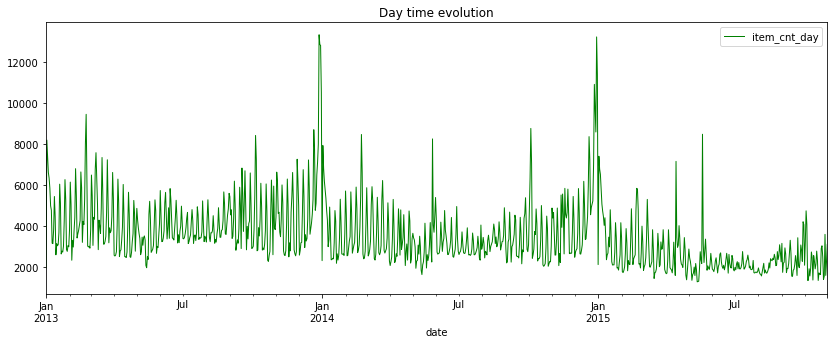

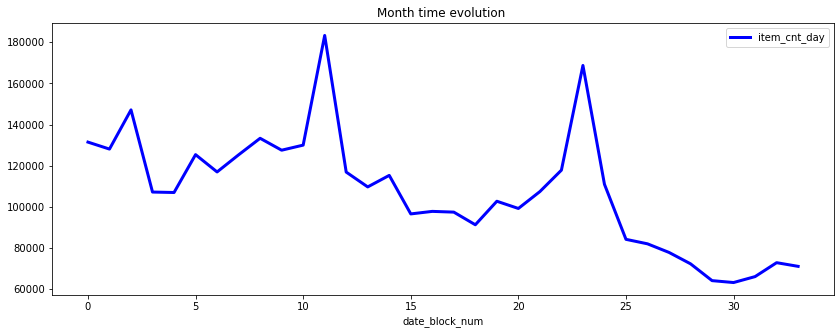

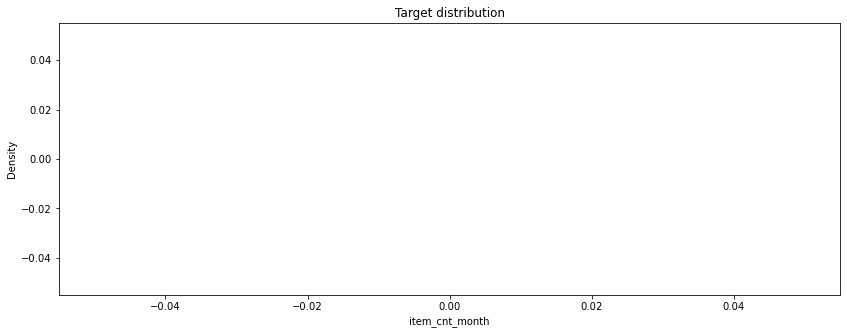

In [39]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
sales_train.groupby('date').agg({'item_cnt_day': 'sum'}).plot(figsize=(14,5), title='Day time evolution', lw=1.0, color='green')
sales_train.groupby('date_block_num').agg({'item_cnt_day': 'sum'}).plot(figsize=(14,5), title='Month time evolution ', lw=3.0, color='blue')
plt.show()

fig, ax = plt.subplots(figsize=(14,5))
ax = sns.kdeplot(df['item_cnt_month'].values, shade=True, color="red", ax=ax)
ax.set_xlabel('item_cnt_month')
ax.set_ylabel('Density')
ax.set_title('Target distribution')
plt.show()

Now check the monthly performance of each shop:

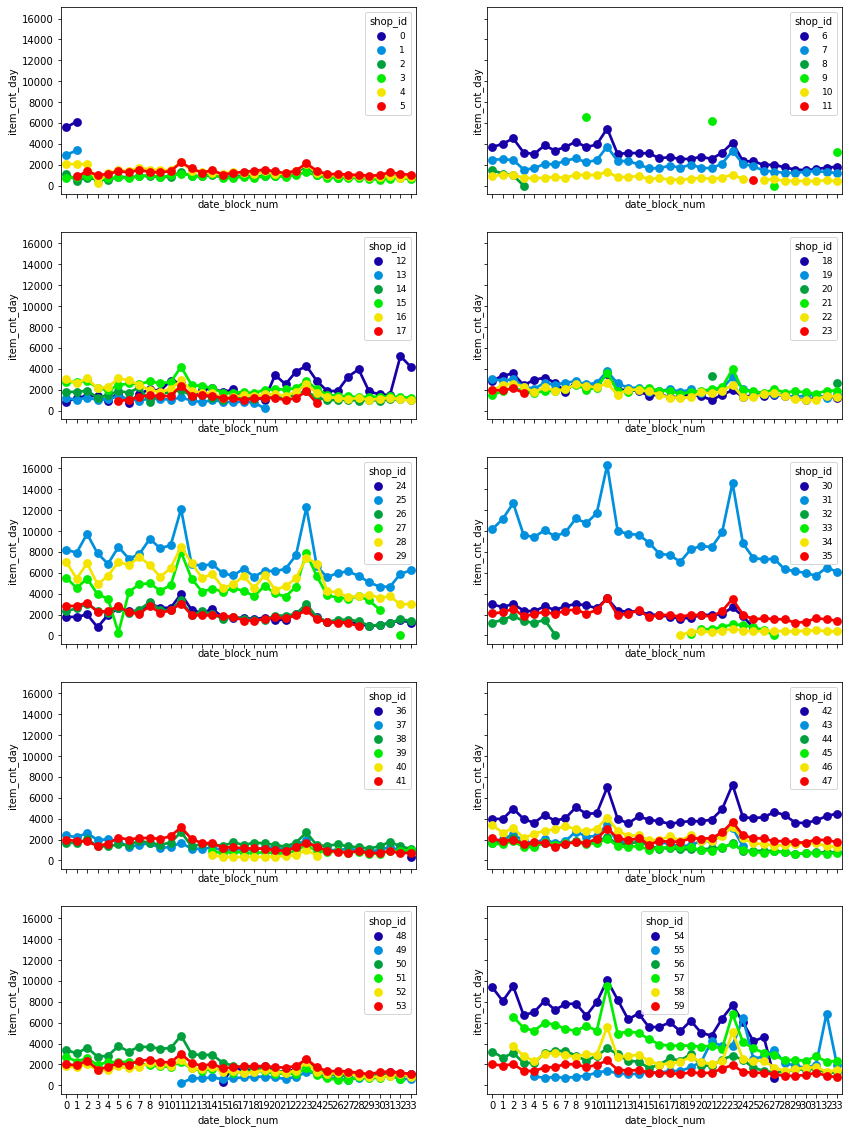

In [40]:
temp = pd.DataFrame(sales_train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(14,20))
num_graph = 10
id_per_graph = ceil(temp.shop_id.max() / num_graph) #temp.shop_id.max() is 59
x = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', palette='nipy_spectral', 
                     data = temp[np.logical_and(x * id_per_graph <= temp['shop_id'],
                                               temp['shop_id'] < (x+1) * id_per_graph)],
                     ax=axes[i][j], grid=True, lw=1.0)
        plt.setp(axes[i][j].get_legend().get_texts(), fontsize='9')
        plt.setp(axes[i][j].get_legend().get_title(), fontsize='10')
        x += 1
# print(temp.shop_id.max())
# temp.head(10)

## 3.2 Multivariate heatmaps

We can pari different categorical variables (ex. `item_category_id`, `shop_id`, `city_code`) together and check the performance of different pairs.

In [41]:
#pair (item_category_id, shop_id)
stores_hm = df.pivot_table(index='shop_id', columns='item_category_id_x', values='item_cnt_month', aggfunc='count', fill_value=0)
stores_hm.head()

item_category_id_x,0,2,3,4,5,6,7,8,9,11,...,74,75,76,77,78,79,80,81,82,83
shop_id,,,,,,,,,,,,,,,,,,,,,
2,1,513,467,58,265,414,276,49,153,198,...,22,1368,1290,315,1236,23,36,12,22,92
3,1,513,467,58,265,414,276,49,153,198,...,22,1368,1290,315,1236,23,36,12,22,92
4,1,513,467,58,265,414,276,49,153,198,...,22,1368,1290,315,1236,23,36,12,22,92
5,1,513,467,58,265,414,276,49,153,198,...,22,1368,1290,315,1236,23,36,12,22,92
6,1,513,467,58,265,414,276,49,153,198,...,22,1368,1290,315,1236,23,36,12,22,92


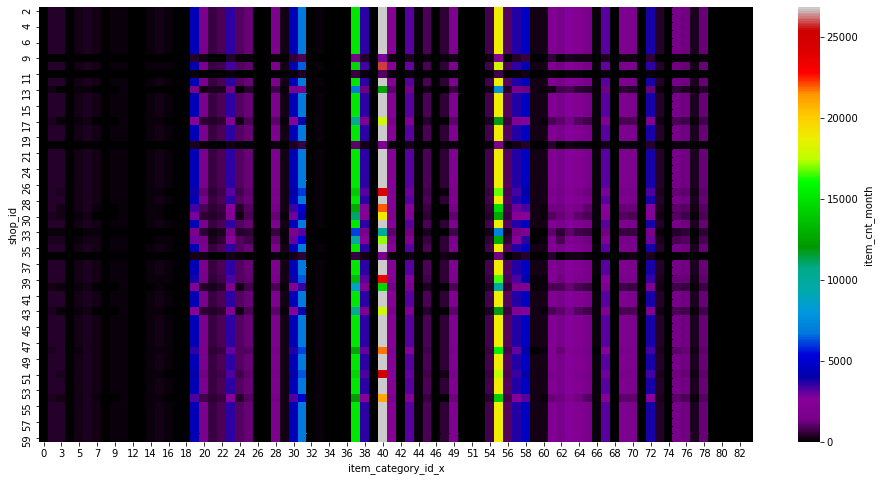

In [42]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

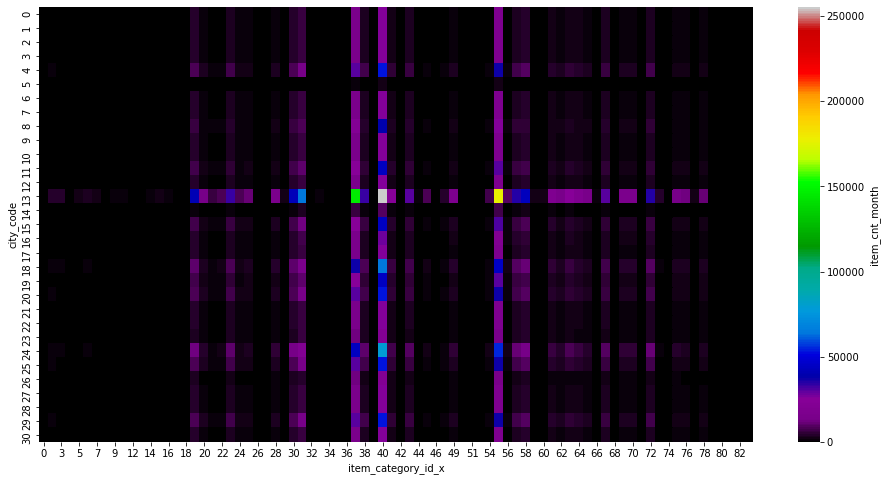

In [43]:
#pair (item_category_id, city_code)
stores_hm = df.pivot_table(index='city_code', columns='item_category_id_x', values='item_cnt_month', aggfunc='count', fill_value=0)
# stores_hm.head()
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

The next figure reveals the number of shops per cities and their sales performance.

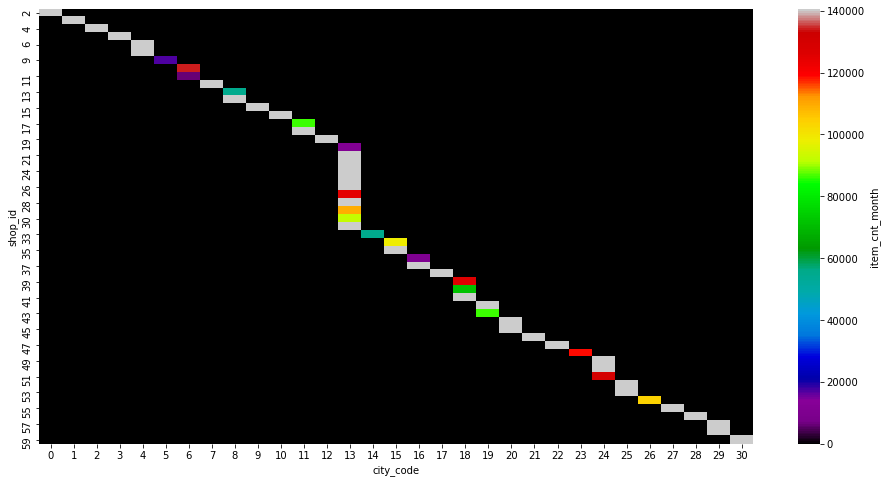

In [44]:
#pair (shop_id, city_code)
stores_hm = df.pivot_table(index='shop_id', columns='city_code', values='item_cnt_month', aggfunc='count', fill_value=0)
# stores_hm.head()
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

Several pairs of shop-item perform better than others, let's exploit this by using target/mean encodings.

# Part4: Advancedd Feature Engineering

## 4.1 Mean encoding on categorical features

Mean encodings look to map a high cardinality categorical feature into a 1D array (instead of high numbers of them had we used one-hot encoding) based on how often the target variable appears on average in the categorical feature. It is a convenient approach since it also has a clever way of imputing missing values among categorical variables.

In [45]:
import copy

In [49]:
df1 = copy.copy(df)
df1.reset_index(inplace=True)

cv = KFold(n_splits=5, shuffle=False)
new_features = []

check = False
for train_idx, valid_idx in cv.split(df1):
    # Train/validation split
    X_train, X_valid = df1.iloc[train_idx,:], df1.iloc[valid_idx,:]
    
    #Mean encoding
    for col in cat_features: #cat_features = ['shop_id', 'item_id', 'city_code', 'item_category_id_x', 'type_code', 'subtype_code']
        means = X_valid[col].map(X_train.groupby(col).item_cnt_month.mean()) #why use X_valid.map??????
        col_new = col + '_target_enc'
        X_valid[col_new] = means
        
        #results
        df1.loc[valid_idx, col_new] = X_valid
        
        #store new columns
        if check is False:
            new_features.append(col_new)
    check = True
        
print(new_features)
# df1.head()

['shop_id_target_enc', 'item_id_target_enc', 'city_code_target_enc', 'item_category_id_x_target_enc', 'type_code_target_enc', 'subtype_code_target_enc']


In [50]:
X_train.head()

,index,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id_x,type_code,subtype_code,date_avg_item_cnt_lag_1,...,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24,shop_id_target_enc,item_id_target_enc,city_code_target_enc,item_category_id_x_target_enc,type_code_target_enc,subtype_code_target_enc
0,0,12,2,27,0.0,0,19,5,10,0.411133,...,0.49858,0.0,0.0,0.0,0.141602,0.040802,0.141602,0.550781,0.570312,0.511230
1,1,12,2,30,0.0,0,40,11,4,0.411133,...,0.49858,0.0,0.0,0.0,0.141602,0.186646,0.141602,0.230835,0.197021,0.230835
2,2,12,2,31,0.0,0,37,11,1,0.411133,...,0.49858,0.0,0.0,0.0,0.141602,0.315186,0.141602,0.157837,0.197021,0.158691
3,3,12,2,32,1.0,0,40,11,4,0.411133,...,0.49858,0.0,0.0,0.0,0.141602,0.575195,0.141602,0.230835,0.197021,0.230835
4,4,12,2,33,1.0,0,37,11,1,0.411133,...,0.49858,0.0,0.0,0.0,0.141602,0.336426,0.141602,0.157837,0.197021,0.158691


In [51]:
X_valid.head()

,index,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id_x,type_code,subtype_code,date_avg_item_cnt_lag_1,...,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24,shop_id_target_enc,item_id_target_enc,city_code_target_enc,item_category_id_x_target_enc,type_code_target_enc,subtype_code_target_enc
5311436,5311436,29,4,2270,0.0,2,23,5,16,0.259521,...,0.423972,0.0,0.0,0.0,0.173706,0.752930,0.173706,0.634766,0.633789,0.615723
5311437,5311437,29,4,2271,0.0,2,24,5,17,0.259521,...,0.423972,0.0,0.0,0.0,0.173706,0.167480,0.173706,0.480469,0.633789,0.515625
5311438,5311438,29,4,2272,0.0,2,31,8,61,0.259521,...,0.423972,0.0,0.0,0.0,0.173706,0.037903,0.173706,0.062103,0.543457,0.070801
5311439,5311439,29,4,2275,0.0,2,31,8,61,0.000000,...,0.423972,0.0,0.0,0.0,0.173706,0.032013,0.173706,0.062103,0.543457,0.070801
5311440,5311440,29,4,2277,0.0,2,31,8,61,0.000000,...,0.423972,0.0,0.0,0.0,0.173706,0.030106,0.173706,0.062103,0.543457,0.070801


In [52]:
#fill missing value with mean of item_cnt_month
new_features = ['shop_id_target_enc', 'item_id_target_enc', 'city_code_target_enc', 'item_category_id_x_target_enc', 'type_code_target_enc', 'subtype_code_target_enc']
prior = np.mean(df1['item_cnt_month'].values)
df1[new_features] = df1[new_features].fillna(prior)
df1.head()

,index,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id_x,type_code,subtype_code,date_avg_item_cnt_lag_1,...,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24,shop_id_target_enc,item_id_target_enc,city_code_target_enc,item_category_id_x_target_enc,type_code_target_enc,subtype_code_target_enc
0,0,12,2,27,0.0,0,19,5,10,0.411133,...,0.49858,0.0,0.0,0.0,0.141602,0.040802,0.141602,0.550781,0.570312,0.511230
1,1,12,2,30,0.0,0,40,11,4,0.411133,...,0.49858,0.0,0.0,0.0,0.141602,0.186646,0.141602,0.230835,0.197021,0.230835
2,2,12,2,31,0.0,0,37,11,1,0.411133,...,0.49858,0.0,0.0,0.0,0.141602,0.315186,0.141602,0.157837,0.197021,0.158691
3,3,12,2,32,1.0,0,40,11,4,0.411133,...,0.49858,0.0,0.0,0.0,0.141602,0.575195,0.141602,0.230835,0.197021,0.230835
4,4,12,2,33,1.0,0,37,11,1,0.411133,...,0.49858,0.0,0.0,0.0,0.141602,0.336426,0.141602,0.157837,0.197021,0.158691


In [57]:
df1.head()

,date_block_num,item_cnt_month,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,...,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24,shop_id_target_enc,item_id_target_enc,city_code_target_enc,item_category_id_x_target_enc,type_code_target_enc,subtype_code_target_enc
0,12,0.0,0.411133,0.086975,0.044434,0.130493,0.065247,0.155518,0.148071,0.100647,...,0.49858,0.0,0.0,0.0,0.141602,0.040802,0.141602,0.550781,0.570312,0.511230
1,12,0.0,0.411133,1.021484,1.022461,0.521973,0.891113,0.000000,0.148071,0.100647,...,0.49858,0.0,0.0,0.0,0.141602,0.186646,0.141602,0.230835,0.197021,0.230835
2,12,0.0,0.411133,0.543457,0.600098,0.543457,0.304443,0.000000,0.148071,0.100647,...,0.49858,0.0,0.0,0.0,0.141602,0.315186,0.141602,0.157837,0.197021,0.158691
3,12,1.0,0.411133,1.934570,1.799805,1.260742,1.891602,5.378906,0.148071,0.100647,...,0.49858,0.0,0.0,0.0,0.141602,0.575195,0.141602,0.230835,0.197021,0.230835
4,12,1.0,0.411133,0.913086,0.333252,0.717285,1.000000,1.355469,0.148071,0.100647,...,0.49858,0.0,0.0,0.0,0.141602,0.336426,0.141602,0.157837,0.197021,0.158691


In [58]:
df1.drop(cat_features, axis=1, inplace=True)
df1.drop('index', axis=1, inplace=True)
cat_features = new_features
df1.columns.values

array(['date_block_num', 'item_cnt_month', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'item_name_tfidf_0', 'item_name_tfidf_1',
       'item_name_tfidf_2', 'item_name_tfidf_3', 'item_name_tfidf_4',
       'item_name_tfidf_5', 'item_name_tfidf_6', 'item_name_tfidf_7',
       'item_name_tf

## 4.2 Matrix factorization of TFIDF processed features

We look to reduce the *dimensionality* of the TFIDF-processed features (from 50 dimensions to 10) and extract nonlinear relationships between the text features with **Non-Negative Matrix Factorization (NMF)**:

In [61]:
tfidf_features = ['item_name_tfidf_0', 'item_name_tfidf_1', 'item_name_tfidf_2',
                  'item_name_tfidf_3', 'item_name_tfidf_4', 'item_name_tfidf_5',
                  'item_name_tfidf_6', 'item_name_tfidf_7', 'item_name_tfidf_8',
                  'item_name_tfidf_9', 'item_name_tfidf_10', 'item_name_tfidf_11',
                  'item_name_tfidf_12', 'item_name_tfidf_13', 'item_name_tfidf_14',
                  'item_name_tfidf_15', 'item_name_tfidf_16', 'item_name_tfidf_17',
                  'item_name_tfidf_18', 'item_name_tfidf_19', 'item_name_tfidf_20',
                  'item_name_tfidf_21', 'item_name_tfidf_22', 'item_name_tfidf_23',
                  'item_name_tfidf_24', 'shop_name_tfidf_0', 'shop_name_tfidf_1',
                  'shop_name_tfidf_2', 'shop_name_tfidf_3', 'shop_name_tfidf_4',
                  'shop_name_tfidf_5', 'shop_name_tfidf_6', 'shop_name_tfidf_7',
                  'shop_name_tfidf_8', 'shop_name_tfidf_9', 'shop_name_tfidf_10',
                  'shop_name_tfidf_11', 'shop_name_tfidf_12', 'shop_name_tfidf_13',
                  'shop_name_tfidf_14', 'shop_name_tfidf_15', 'shop_name_tfidf_16',
                  'shop_name_tfidf_17', 'shop_name_tfidf_18', 'shop_name_tfidf_19',
                  'shop_name_tfidf_20', 'shop_name_tfidf_21', 'shop_name_tfidf_22',
                  'shop_name_tfidf_23', 'shop_name_tfidf_24']

X_train = df1[df1['date_block_num'] < 34][tfidf_features]
X_test = df1[df1['date_block_num'] == 34][tfidf_features]
print(X_train.shape, X_test.shape)

(6425094, 50) (214200, 50)


In [62]:
nmf = NMF(n_components=10, init=None, solver='cd', beta_loss='frobenius', tol=0.0001, max_iter=200)
nmf.fit(df1[tfidf_features])

NMF(n_components=10)

In [63]:
X_train = nmf.transform(X_train)
X_test = nmf.transform(X_test)
print(X_train.shape, X_test.shape)

(6425094, 10) (214200, 10)


In [68]:
df1.drop(tfidf_features, axis=1, inplace=True)

In [69]:
df1.head()

,date_block_num,item_cnt_month,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,...,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,shop_id_target_enc,item_id_target_enc,city_code_target_enc,item_category_id_x_target_enc,type_code_target_enc,subtype_code_target_enc
0,12,0.0,0.411133,0.086975,0.044434,0.130493,0.065247,0.155518,0.148071,0.100647,...,0.0,1.075195,-0.282795,1.230799,0.141602,0.040802,0.141602,0.550781,0.570312,0.511230
1,12,0.0,0.411133,1.021484,1.022461,0.521973,0.891113,0.000000,0.148071,0.100647,...,0.0,0.291504,-0.483264,1.230799,0.141602,0.186646,0.141602,0.230835,0.197021,0.230835
2,12,0.0,0.411133,0.543457,0.600098,0.543457,0.304443,0.000000,0.148071,0.100647,...,0.0,0.234009,-0.137618,1.230799,0.141602,0.315186,0.141602,0.157837,0.197021,0.158691
3,12,1.0,0.411133,1.934570,1.799805,1.260742,1.891602,5.378906,0.148071,0.100647,...,0.0,0.291504,-0.407143,1.230799,0.141602,0.575195,0.141602,0.230835,0.197021,0.230835
4,12,1.0,0.411133,0.913086,0.333252,0.717285,1.000000,1.355469,0.148071,0.100647,...,1.0,0.234009,-0.225177,1.230799,0.141602,0.336426,0.141602,0.157837,0.197021,0.158691


In [70]:
tfidf_reduced_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_test)], axis=0)
tfidf_reduced_df.columns = ['tfidf_interaction_1', 'tfidf_interaction_2', 'tfidf_interaction_3',
                            'tfidf_interaction_4', 'tfidf_interaction_5', 'tfidf_interaction_6',
                            'tfidf_interaction_7', 'tfidf_interaction_8', 'tfidf_interaction_9',
                            'tfidf_interaction_10']
print(tfidf_reduced_df.shape)
tfidf_reduced_df.head()

(6639294, 10)


,tfidf_interaction_1,tfidf_interaction_2,tfidf_interaction_3,tfidf_interaction_4,tfidf_interaction_5,tfidf_interaction_6,tfidf_interaction_7,tfidf_interaction_8,tfidf_interaction_9,tfidf_interaction_10
0,0.002106,0.0,0.000000,0.0,0.0,0.030448,0.015749,0.0,0.0,0.000039
1,0.001958,0.0,0.000000,0.0,0.0,0.030108,0.000000,0.0,0.0,0.000000
2,0.001768,0.0,0.035745,0.0,0.0,0.030164,0.000000,0.0,0.0,0.000000
3,0.001958,0.0,0.000000,0.0,0.0,0.030108,0.000000,0.0,0.0,0.000000
4,0.001768,0.0,0.035745,0.0,0.0,0.030164,0.000000,0.0,0.0,0.000000


In [72]:
for col in tfidf_reduced_df.columns:
    print(col)
    test1 = tfidf_reduced_df[col].values
    df1[col] = test1
df1.head()

tfidf_interaction_1
tfidf_interaction_2
tfidf_interaction_3
tfidf_interaction_4
tfidf_interaction_5
tfidf_interaction_6
tfidf_interaction_7
tfidf_interaction_8
tfidf_interaction_9
tfidf_interaction_10


,date_block_num,item_cnt_month,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,...,tfidf_interaction_1,tfidf_interaction_2,tfidf_interaction_3,tfidf_interaction_4,tfidf_interaction_5,tfidf_interaction_6,tfidf_interaction_7,tfidf_interaction_8,tfidf_interaction_9,tfidf_interaction_10
0,12,0.0,0.411133,0.086975,0.044434,0.130493,0.065247,0.155518,0.148071,0.100647,...,0.002106,0.0,0.000000,0.0,0.0,0.030448,0.015749,0.0,0.0,0.000039
1,12,0.0,0.411133,1.021484,1.022461,0.521973,0.891113,0.000000,0.148071,0.100647,...,0.001958,0.0,0.000000,0.0,0.0,0.030108,0.000000,0.0,0.0,0.000000
2,12,0.0,0.411133,0.543457,0.600098,0.543457,0.304443,0.000000,0.148071,0.100647,...,0.001768,0.0,0.035745,0.0,0.0,0.030164,0.000000,0.0,0.0,0.000000
3,12,1.0,0.411133,1.934570,1.799805,1.260742,1.891602,5.378906,0.148071,0.100647,...,0.001958,0.0,0.000000,0.0,0.0,0.030108,0.000000,0.0,0.0,0.000000
4,12,1.0,0.411133,0.913086,0.333252,0.717285,1.000000,1.355469,0.148071,0.100647,...,0.001768,0.0,0.035745,0.0,0.0,0.030164,0.000000,0.0,0.0,0.000000


In [73]:
print(df1.shape)
print(df1.columns.values)

array(['date_block_num', 'item_cnt_month', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'shop_id_target_enc', 'item_id_target_enc',
       'city_code_target_enc', 'item_category_id_x_target_enc',
       'type_code_target_enc', 'subtype_code_target_enc',
       'tfidf_interaction_1', 'tfidf

In [74]:
df1.to_csv('data.csv')

In [ ]:
# df1 = pd.read_csv('data.csv', index_col=0)

# Part 5: Model Training

We will implement the following models:

- **Linear Regression**: preproccing is required and we will use `StandardScaler`;
- **XGBoost / LightBGM**: no preproccesing as decision tree are capable of handling features with different scales.

## 5.1 Validation scheme

We choose **holdout** as out validation scheme: out training set runs from Jan.2013 to Sep.2015, validation set runs on Oct.2015. The test set runs on Nov.2015. 

In [75]:
all_data = copy.copy(df1)

X_train = all_data[all_data['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']

X_valid = all_data[all_data['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

X_test = all_data[all_data['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

(6186922, 38)
(6186922,)
(238172, 38)
(238172,)
(214200, 38)


In [76]:
X_test.head()

,date_block_num,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,...,tfidf_interaction_1,tfidf_interaction_2,tfidf_interaction_3,tfidf_interaction_4,tfidf_interaction_5,tfidf_interaction_6,tfidf_interaction_7,tfidf_interaction_8,tfidf_interaction_9,tfidf_interaction_10
6425094,34,0.258545,0.568359,2.511719,2.833984,1.977539,1.299805,0.190063,0.205933,0.245117,...,0.000000,0.033106,0.0,0.0,0.0,0.000135,0.001807,0.000000,0.00000,0.000046
6425095,34,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000396,0.034072,0.0,0.0,0.0,0.000466,0.000000,0.001301,0.00138,0.000601
6425096,34,0.258545,0.954590,1.860352,3.572266,1.613281,0.000000,0.190063,0.205933,0.245117,...,0.000000,0.032815,0.0,0.0,0.0,0.000014,0.015497,0.000000,0.00000,0.000000
6425097,34,0.258545,0.636230,1.116211,1.547852,0.000000,0.000000,0.190063,0.205933,0.245117,...,0.000000,0.033210,0.0,0.0,0.0,0.000252,0.012283,0.000186,0.00000,0.000178
6425098,34,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.032365,0.0,0.0,0.0,0.000000,0.019217,0.000000,0.00000,0.000000


## 5.2 LightGBM Regressor

The correct metric to be used is **root mean squared error**

Our first model is regularized gradient boosting LightGBM.

In [94]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Lars, ElasticNet
# from sklearn.externals import joblib
import joblib

import lightgbm as lgb
import xgboost as xgb

In [84]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_valid, Y_valid)

params = {
    'boosting_type': 'dart',
    'metric': 'l2_root', # RMSE
    'verbose': 1,
    'seed': 0,
    'max_depth': 8,
    'learning_rate': 0.1,
    'reg_lambda': 2.0,
    'reg_alpha': 2.0,
    'subsample': 0.7,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'drop_rate': 0.2
}

#next time, try to use GPU rather than CPU
model_lgbm = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_valid,
                      early_stopping_rounds=200, categorical_feature=cat_features, verbose_eval=50)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.689825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 6186922, number of used features: 38
[LightGBM] [Info] Start training from score 0.288849
[50]	valid_0's rmse: 0.99856
[100]	valid_0's rmse: 0.972377
[150]	valid_0's rmse: 0.967661
[200]	valid_0's rmse: 0.962491
[250]	valid_0's rmse: 0.961826
[300]	valid_0's rmse: 0.96108
[350]	valid_0's rmse: 0.960029
[400]	valid_0's rmse: 0.958155
[450]	valid_0's rmse: 0.957593
[500]	valid_0's rmse: 0.95651
[550]	valid_0's rmse: 0.959422
[600]	valid_0's rmse: 0.962823
[650]	valid_0's rmse: 0.960635
[700]	valid_0's rmse: 0.961457
[750]	valid_0's rmse: 0.963179
[800]	valid_0's rmse: 0.963088
[850]	valid_0's rmse: 0.959727
[900]	valid_0's rmse: 0.961612
[950]	valid_0's rmse: 0.961361
[100

In [85]:
print(np.sqrt(mean_squared_error(Y_valid, model_lgbm.predict(X_valid))))

0.9592583353498724


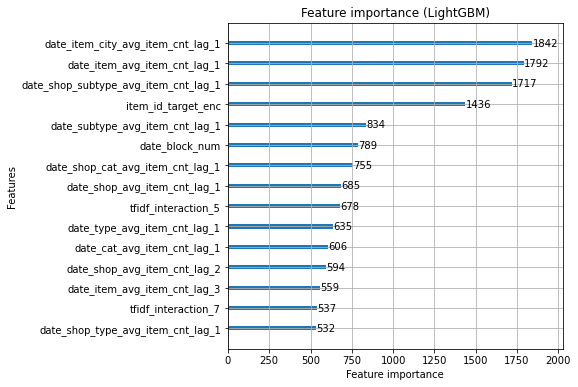

In [87]:
lgb.plot_importance(model_lgbm, max_num_features=15, figsize=(6,6), title='Feature importance (LightGBM)')
plt.show()

In [90]:
joblib.dump(model_lgbm, 'models/model1_lgbm.pkl');

In [92]:
model_lgbm = joblib.load('models/model1_lgbm.pkl') #how to save and check the parameters when load???

In [ ]:
# model_lgbm.save_model('models/model1_lgbm_txt.txt') #save
# model_lgbm_txt = lgb.Booster(model_file='models/model1_lgbm_txt.txt') #load

## 5.3 XGBoost Regressor

Now we try XGBoost library.

In [96]:
model_xgb = xgb.XGBRegressor(max_depth=8, n_estimators=1000, min_child_weight=300,
                            colsample_bytree=0.8, subsample=0.8, eta=0.2, seed=42,
                            reg_alpha=0.2, reg_lambda=2.0)

model_xgb.fit(X_train, Y_train, eval_metric='rmse', eval_set=[(X_valid, Y_valid)],
             verbose=False, early_stopping_rounds=1000)  #start:10:29pm, end 1:23am



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0.2, reg_lambda=2.0, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [98]:
print(np.sqrt(mean_squared_error(Y_valid, model_xgb.predict(X_valid))))

0.95898634


In [99]:
joblib.dump(model_xgb, 'models/model2_xgb.pkl');

In [100]:
model_xgb = joblib.load('models/model2_xgb.pkl')

In [101]:
print(model_xgb.best_iteration)

8


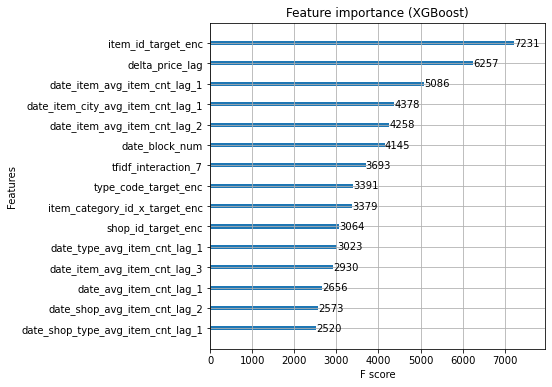

In [102]:
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(model_xgb, max_num_features=15, title='Feature importance (XGBoost)', ax=ax)
plt.show()

## 5.4 Linear regression

We implement linear models `LinearRegression`, `Ridge`, `Lasso` as benchmarks.We need to implement *feature scaling* before fitting on the dataset.

**LinearRegression** model:

In [103]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)

In [105]:
model_linreg = LinearRegression(fit_intercept=True)
model_linreg.fit(X_train_std, Y_train)

LinearRegression()

In [106]:
print(np.sqrt(mean_squared_error(Y_valid, model_linreg.predict(X_valid_std))))

0.9900068230768748


In [107]:
joblib.dump(model_linreg, 'models/model3_linreg.pkl');

**Ridge** model:

In [108]:
model_ridge = Ridge(alpha=4.0, fit_intercept=True, max_iter=1000, solver='saga')
model_ridge.fit(X_train_std, Y_train)

Ridge(alpha=4.0, max_iter=1000, solver='saga')

In [109]:
print(np.sqrt(mean_squared_error(Y_valid, model_ridge.predict(X_valid_std))))

0.9900218546886506


In [113]:
joblib.dump(model_ridge, 'models/model4_ridge.pkl');

**Lasso** model:

In [111]:
model_lasso = Lasso(alpha=10.0, fit_intercept=True, max_iter=1000)
model_lasso.fit(X_train_std, Y_train)

Lasso(alpha=10.0)

In [112]:
print(np.sqrt(mean_squared_error(Y_valid, model_lasso.predict(X_valid_std))))

1.1365538511881084


In [114]:
joblib.dump(model_lasso, 'models/model5_lasso.pkl');

# Part 6: Ensembling and test predictions

## 6.1 Ensembling: LightGBM + Linear Regression

We will implement the KFold scheme time series implemented in the previous assignment.

  1. Split the train data into chunks of duration T, select first M chunks.
  2. Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until the end. After that, use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from M+1 and meta-features for test.
  3. Now we can use meta-features from first K chunks [M+1, M+2, ..., M+K] to fit level 2 models and validate them on chunk M+K+1.Essentially we are back to step 1 with lesser amount of chunks and meta-features instead of features.
  
We start with **1st generation features**:

In [115]:
del X_train, X_test, tfidf_reduced_df
gc.collect()

37422

In [117]:
model_lgbm = joblib.load('models/model1_lgbm.pkl')
model_linreg = joblib.load('models/model3_linreg.pkl')

In [118]:
Y_valid_lgbm = model_lgbm.predict(X_valid)
Y_valid_lreg = model_linreg.predict(X_valid_std)
X_valid_level2 = np.c_[Y_valid_lgbm, Y_valid_lreg]
X_valid_level2[:10,:]

array([[ 0.02589896, -0.06268361],
       [ 0.10699321, -0.0409064 ],
       [ 0.13325116,  0.1159285 ],
       [ 0.24816083,  0.40087099],
       [ 0.03419014,  0.0099343 ],
       [ 0.00458137, -0.08367468],
       [ 0.01517162, -0.09088274],
       [ 0.0192622 , -0.10314817],
       [ 0.0192622 , -0.10571339],
       [ 0.01998308, -0.09372047]])

Then **2nd generation feature**:

In [119]:
X_train = all_data[all_data['date_block_num']<=32].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data['date_block_num']<=32]['item_cnt_month']
X_valid = all_data[all_data['date_block_num']==33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data['date_block_num']==33]['item_cnt_month']

In [124]:
dates = all_data['date_block_num']
last_block = dates.max()
print('Test date_block_num is ',last_block)
dates_train = dates[dates < last_block]
dates_test = dates[dates == last_block]

Test date_block_num is  34


In [125]:
periods = np.arange(26, 33, 1)
periods

array([26, 27, 28, 29, 30, 31, 32])

In [130]:
dates_train_level2 = dates_train[dates_train.isin(periods)]
Y_train_level2 = Y_train[dates_train.isin(periods)]
X_train_level2 = np.zeros([Y_train_level2.shape[0], 2])

In [131]:
Y_train[dates_train.isin(periods)].shape == dates_train_level2.shape

True

In [ ]:
# cur_block_num = 26
# x = all_data[all_data['date_block_num'] < cur_block_num].drop(['item_cnt_month'], axis=1)
# y = all_data[all_data['date_block_num'] < cur_block_num]['item_cnt_month'].values
# x_test = all_data[all_data['date_block_num'] == cur_block_num].drop(['item_cnt_month'], axis=1)
# y = all_data[all_data['date_block_num'] == cur_block_num]['item_cnt_month'].values

In [133]:
#Now fill 'X_train_level2' with metafeatures

#params for lightGBM
params = {
    'boosting_type': 'dart',
    'metric': 'l2_root', # RMSE
    'verbose': 1,
    'seed': 0,
    'max_depth': 8,
    'learning_rate': 0.1,
    'reg_lambda': 2.0,
    'reg_alpha': 2.0,
    'subsample': 0.7,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'drop_rate': 0.2
}

for cur_block_num in periods:
    
    print('cur_block_num:', cur_block_num)
    
    # 1. split X_train into parts
    x = all_data[all_data['date_block_num'] < cur_block_num].drop(['item_cnt_month'], axis=1)
    y = all_data[all_data['date_block_num'] < cur_block_num]['item_cnt_month'].values
    x_test = all_data[all_data['date_block_num'] == cur_block_num].drop(['item_cnt_month'], axis=1)
    y_test = all_data[all_data['date_block_num'] == cur_block_num]['item_cnt_month'].values
    
    #2. Fit Linear regression
    print('Fitting Linear Regression:')
    lr = LinearRegression(fit_intercept=True, normalize=True)
    scaler = StandardScaler().fit(x)
    x_std = scaler.transform(x)
    x_test_std = scaler.transform(x_test)
    lr.fit(x_std, y)
    Y_test_1 = lr.predict(x_test_std)
    
    # 3. Fit LightGBM and prediction
    print('LightGBM:')
    n_trees = 500
    lgb_train = lgb.Dataset(x, y)
    lgb_valid = lgb.Dataset(x_test, y_test)
    model_lgbm = lgb.train(params, lgb_train, num_boost_round=n_trees, valid_sets=lgb_valid,
                          early_stopping_rounds=50, verbose_eval=50)
    Y_test_2 = model_lgbm.predict(x_test)
    
    # 4. Store predictions from 2 & 3 to 'X_train_level2'
    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[Y_test_1, Y_test_2]
    clear_output()
    
print(X_train_level2.mean(axis=0))

    

[0.31901801 0.27418145]


In [147]:
np.savez('X_train_level2.npz',X_train_level2=X_train_level2)

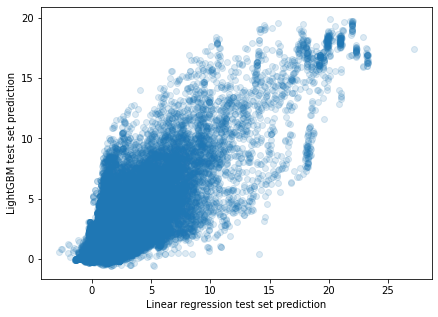

In [134]:
plt.figure(figsize=(7,5))
plt.scatter(X_train_level2[:,0], X_train_level2[:,1], marker='o', alpha=0.15)
plt.xlabel('Linear regression test set prediction')
plt.ylabel('LightGBM test set prediction')
plt.show()

Now we can do **stacking**.

In [135]:
Y_train_level2 = Y_train[dates_train.isin(periods)]
lr_stack = LinearRegression().fit(X_train_level2, Y_train_level2)

In [139]:
train_preds = lr_stack.predict(X_train_level2)
rmse_train = np.sqrt(mean_squared_error(Y_train_level2, train_preds))

valid_preds = lr_stack.predict(X_valid_level2)
rmse_valid = np.sqrt(mean_squared_error(Y_valid, valid_preds))

print('RMSE train: ', rmse_train)
print('RMSE test: ', rmse_valid)

RMSE train:  0.8084703370608785
RMSE test:  0.9796078536475548


## 6.2 Leaderboard test predictions

In [143]:
X_test =  all_data[all_data['date_block_num']==34].drop(['item_cnt_month'], axis=1)

Y_test_lgbm = model_lgbm.predict(X_test).clip(0, 20)
Y_test_xgbm = model_xgb.predict(X_test).clip(0, 20)
Y_test_lreg = model_linreg.predict(X_test).clip(0, 20)
Y_test_ridge = model_ridge.predict(X_test).clip(0, 20)
Y_test_lasso = model_lasso.predict(X_test).clip(0, 20)

In [145]:
models = [Y_test_lgbm, Y_test_xgbm, Y_test_lreg, Y_test_ridge,
          Y_test_lasso]
names = ['LGBM', 'XGBM', 'LINREG', 'RIDGE', 'LASSO']

for model, name in zip(models, names):
    temp = pd.DataFrame({'ID': test.index, 'item_cnt_month': model})
    temp.to_csv('submissions/submission_' + str(name) + '.csv', index=False)
    

Public leaderboard **Score**:
- XGBoost: 0.98971
- LightGBM: 0.98313
- LinearRegression: 1.07821
- Ridge: 1.07822
- Lasso: 1.21744

My office submission is LightGBM. Writing the data to `submission.cvs`.

In [146]:
temp = pd.DataFrame({'ID': test.index, 'item_cnt_month': Y_test_lgbm})
temp.to_csv('submissions/submission.csv', index=False)